In [238]:
import numpy as np
import random
import cv2

def generate_dust_mask(
    image_shape=(1024, 1024),
    num_blobs=250,
    num_scratches=4,
    num_hairs=50,
    max_blob_size=1,
    max_scratch_length=240,
    max_hair_length=20,
    squiggliness=1,
    scale_factor=4  # supersampling factor
):
    """
    Returns a float32 dust mask using supersampling anti-aliasing and performance optimizations.
    """

    h, w = image_shape
    H, W = h * scale_factor, w * scale_factor  # high-res dimensions
    mask_hi = np.zeros((H, W), dtype=np.uint8)
    temp = np.zeros_like(mask_hi)  # shared buffer

    def rand_count(base):
        return random.randint(int(base * 0.8), int(base * 1.2))

    # Vary counts
    num_blobs = rand_count(num_blobs)
    num_scratches = rand_count(num_scratches)
    num_hairs = rand_count(num_hairs)
    max_blob_size = max(1, max_blob_size + random.randint(-1, 2))

    # --- Blobs ---
    for _ in range(num_blobs):
        temp.fill(0)
        center = (random.randint(0, W), random.randint(0, H))
        axes = (
            random.randint(max(1, max_blob_size - 1), max_blob_size + 1) * scale_factor,
            random.randint(1, max(1, max_blob_size // 2) + 1) * scale_factor
        )
        angle = random.randint(0, 180)
        cv2.ellipse(temp, center, axes, angle, 0, 360, 255, -1)
        opacity = random.uniform(0.3, 1.0)
        mask_hi = cv2.addWeighted(mask_hi, 1.0, temp, opacity, 0)

    # --- Scratches ---
    for _ in range(num_scratches):
        temp.fill(0)
        x1, y1 = random.randint(0, W), random.randint(0, H)
        angle = random.uniform(0, 2 * np.pi)
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        length = random.randint(int(max_scratch_length * 0.7), int(max_scratch_length * 1.3)) * scale_factor
        x2 = int(x1 + length * cos_a)
        y2 = int(y1 + length * sin_a)
        thickness = scale_factor  # minimum visible thickness
        cv2.line(temp, (x1, y1), (x2, y2), 255, thickness)
        opacity = random.uniform(0, 1.0)
        mask_hi = cv2.addWeighted(mask_hi, 1.0, temp, opacity, 0)

    # --- Hairs (curved, with polylines) ---
    for _ in range(num_hairs):
        temp.fill(0)
        points = []
        x, y = random.randint(0, W), random.randint(0, H)
        hair_length = random.randint(int(max_hair_length * 0.8), int(max_hair_length * 1.2)) * scale_factor
        num_segments = max(3, hair_length // random.randint(8, 12))
        hair_squiggliness = squiggliness * random.uniform(0.8, 1.2)

        angle = random.uniform(0, 2 * np.pi)
        dx_base = np.cos(angle)
        dy_base = np.sin(angle)

        for _ in range(num_segments):
            segment_length = random.uniform(8, 12) * scale_factor
            dx = dx_base * segment_length + hair_squiggliness * random.uniform(-segment_length, segment_length)
            dy = dy_base * segment_length + hair_squiggliness * random.uniform(-segment_length, segment_length)
            x = int(np.clip(x + dx, 0, W - 1))
            y = int(np.clip(y + dy, 0, H - 1))
            points.append((x, y))

        if len(points) >= 2:
            pts = np.array(points, dtype=np.int32)
            thickness = random.randint(1, 2) * scale_factor
            cv2.polylines(temp, [pts], isClosed=False, color=255, thickness=thickness, lineType=cv2.LINE_AA)
            opacity = random.uniform(0, 1.0)
            mask_hi = cv2.addWeighted(mask_hi, 1.0, temp, opacity, 0)

    # --- Downsample and Normalize ---
    mask_lo = cv2.resize(mask_hi, (w, h), interpolation=cv2.INTER_AREA)
    return mask_lo.astype(np.float32) / 255.0

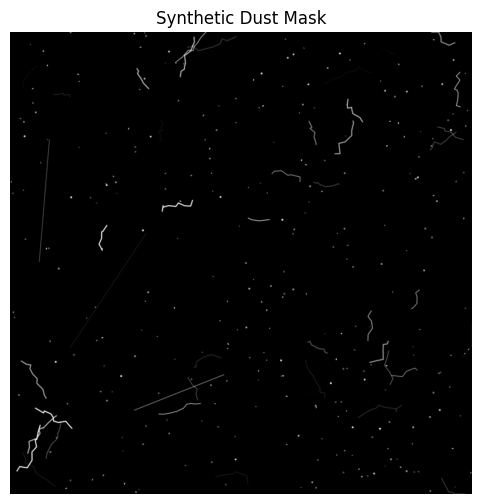

In [239]:
import matplotlib.pyplot as plt

mask = generate_dust_mask(image_shape=(1024, 1024))

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray', interpolation='bilinear')
plt.title("Synthetic Dust Mask")
plt.axis('off')
plt.show()

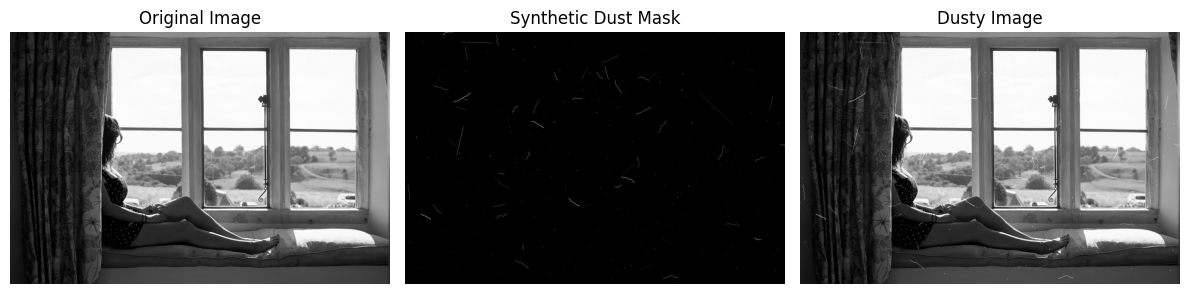

In [240]:
def apply_dust_to_greyscale_image(image_grey, mask, intensity=255):
    mask_float = mask.astype(np.float32)  # Already in [0.0, 1.0]
    image_float = image_grey.astype(np.float32)
    image_float += mask_float * intensity
    return np.clip(image_float, 0, 255).astype(np.uint8)

# ---- Load Image ----
img_path = "film-dataset/1216x806x2 (8)-topaz-denoise.jpeg"
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Could not read {img_path}")

# Convert to greyscale
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image_grey.shape

# ---- Generate Mask & Apply ----
mask = generate_dust_mask(image_shape=(h, w), squiggliness=0.7)
dusty_image = apply_dust_to_greyscale_image(image_grey, mask, intensity=255)

# ---- Visualize ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_grey, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Synthetic Dust Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dusty_image, cmap='gray')
plt.title("Dusty Image")
plt.axis('off')

plt.tight_layout()
plt.show()
plt.imsave("dusty_image.png", dusty_image, cmap='gray')


In [172]:
!pip install torch torchvision albumentations matplotlib scikit-image opencv-python tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [albumentations]m [albucore]thon-headless]


In [46]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
from torchvision import transforms

class DustDataset(Dataset):
    def __init__(self, root_dir, image_size=(1024, 1024), transform=None):  # Increased to 1024x1024
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        clean_img = cv2.imread(path)
        
        # Convert to greyscale
        if len(clean_img.shape) == 3:
            clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2GRAY)
        
        # Resize image to 1024x1024
        clean_img = cv2.resize(clean_img, self.image_size)

        # generate synthetic dust mask with enhanced randomness
        mask = generate_dust_mask(image_shape=self.image_size, squiggliness=random.uniform(0.5, 1.5))

        # apply dust to the clean image using the mask with variable intensity
        dust_intensity = random.randint(150, 255)  # More variation in dust intensity
        dusty_img = apply_dust_to_greyscale_image(clean_img, mask, intensity=dust_intensity)

        # Normalize and prepare inputs - convert greyscale to single channel format
        image = dusty_img.astype(np.float32) / 255.0
        image = image[..., np.newaxis]  # Add channel dimension: HW -> HW1
        mask = mask.astype(np.float32)[..., np.newaxis]  # HW -> HW1, already in [0, 1] range

        # Apply augmentation (optional)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # CHW format
        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))

        return image, mask

In [47]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Augmentations for greyscale images (removing RGB-only transforms)
transform = A.Compose([
    # Geometric transforms - films can be scanned at slight angles
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=5, p=0.4),  # Small rotations for scanning variations
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=3, p=0.3)
])

/Users/yahyarahhawi/miniforge3/envs/ml/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [33]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU()
            )

        # Back to 1 channel for greyscale
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)           # 512
        e2 = self.enc2(self.pool(e1))  # 256
        e3 = self.enc3(self.pool(e2))  # 128
        e4 = self.enc4(self.pool(e3))  # 64

        m = self.middle(self.pool(e4))  # 32

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))  # 64
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1)) # 128
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1)) # 256
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1)) # 512

        return torch.sigmoid(self.final(d1))  # 1x512x512

In [49]:
import torch
import torch.nn as nn

def dice_bce_loss(pred, target, smooth=1e-5):
    """Combined Dice and BCE loss for better segmentation performance"""
    bce = nn.BCELoss()(pred, target)
    
    # Flatten tensors for dice calculation
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    
    intersection = (pred_flat * target_flat).sum()
    dice = (2 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    
    return bce + (1 - dice)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
dataset = DustDataset("film-dataset", image_size=(1024, 1024), transform=transform)  # 1024x1024
loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Reduced batch size for 1024x1024

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)  # Lower learning rate for larger images
criterion = nn.BCELoss()



os.makedirs("checkpoints", exist_ok=True)
model.load_state_dict(torch.load('checkpoints/unet_epoch34.pth'))
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    # Save weights for each epoch
    torch.save(model.state_dict(), f"checkpoints/bce_unet_epoch{epoch+1:02d}.pth")



TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [32]:
def predict_dust_mask(model, weights_path, image_path, threshold=0.5, window_size=1024, stride=512, device=None):
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # ✅ Use MPS if available

    # Load model
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Load image
    image = Image.open(image_path).convert('L')
    image_np = np.array(image).astype(np.float32)
    H, W = image_np.shape

    # Pad image
    pad_h = (window_size - H % stride) % stride
    pad_w = (window_size - W % stride) % stride
    padded = np.pad(image_np, ((0, pad_h), (0, pad_w)), mode='reflect')
    pH, pW = padded.shape

    prediction_map = np.zeros((pH, pW), dtype=np.float32)
    count_map = np.zeros((pH, pW), dtype=np.float32)

    with torch.no_grad():
        for y in range(0, pH - window_size + 1, stride):
            for x in range(0, pW - window_size + 1, stride):
                patch = padded[y:y+window_size, x:x+window_size]
                patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0) / 255.0
                patch_tensor = patch_tensor.to(device)
                pred = model(patch_tensor)
                pred_np = pred.squeeze().cpu().numpy()
                prediction_map[y:y+window_size, x:x+window_size] += pred_np
                count_map[y:y+window_size, x:x+window_size] += 1.0

    final_mask = prediction_map / np.maximum(count_map, 1e-8)
    final_mask = final_mask[:H, :W]

    return final_mask

In [39]:
image_path = "2_altered.jpg"
weights_path = "v3_bce_unet_epoch03.pth"
model = UNet()
model.to(torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
dust = predict_dust_mask(model, weights_path, image_path, threshold=0.2, window_size=1024, stride=980)


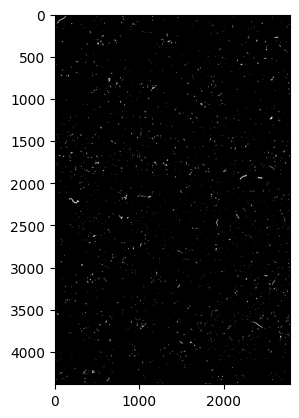

In [40]:
import skimage.io as skio
import matplotlib.pyplot as plt
plt.imshow( dust>0.01, cmap='gray')

In [41]:
def inpaint_dusty_image(dusty_image, dust_mask, threshold=0.2):
    """
    Inpaint the dusty image using the dust mask.
    """
    # Convert mask to binary
    
    binary_mask = (dust_mask > threshold).astype(np.uint8)

    # Dilate the mask to cover more dust
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    # Inpaint the dusty image
    inpainted_image = cv2.inpaint(dusty_image, binary_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inpainted_image

In [66]:
import torch
import torch.nn as nn
import coremltools as ct
import numpy as np

# Load your model (scaled or original)
model = UNet()
model.load_state_dict(torch.load("v5_bce_unet_epoch39.pth", map_location="cpu"))
model.eval()

# Example input
example_input = torch.rand(1, 1, 1024, 1024)

# Trace model
traced = torch.jit.trace(model, example_input)

# Convert to Core ML with MultiArray output (preserves continuous values)
mlmodel = ct.convert(
    traced,
    inputs=[ct.ImageType(
        name="input",
        shape=example_input.shape,
        scale=1.0 / 255.0,
        bias=[0.0],
        color_layout=ct.colorlayout.GRAYSCALE
    )],
    outputs=[ct.TensorType(
        name="output",
        shape=(1, 1, 1024, 1024)  # Batch, Channel, Height, Width
    )],
    convert_to="mlprogram"
)

mlmodel.author = "Yahya Rahhawi"
mlmodel.short_description = "UNet model for grayscale dust mask segmentation (MultiArray output)"
mlmodel.save("UNetDust.mlpackage")

ValueError: The 'shape' argument must not be specified for the outputs, since it is automatically inferred from the input shapes and the ops in the model

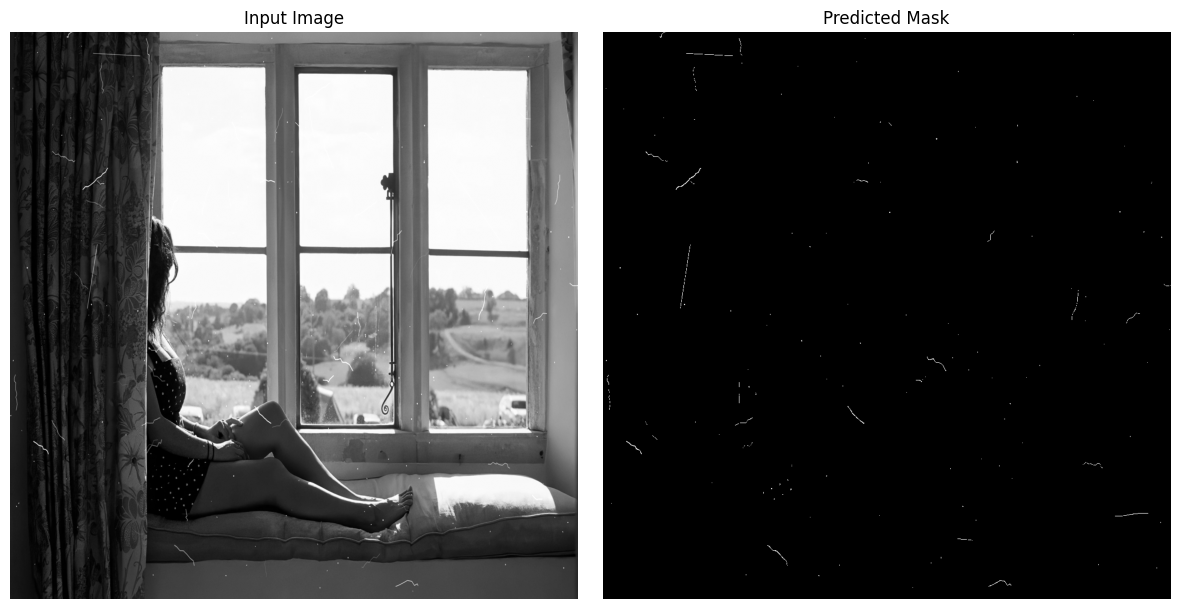

In [ ]:
import coremltools as ct
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load Core ML model
mlmodel = ct.models.MLModel("UNetDust.mlpackage")

# Load and prepare image
img_path = "/Users/yahyarahhawi/Developer/Dust-Removal-UNet/dusty_image.png"
input_image = Image.open(img_path).convert('L').resize((1024, 1024))

# Predict using CoreML
out_dict = mlmodel.predict({"input": input_image})
output = out_dict["output"]  # This will be a MultiArray

# Convert MultiArray to numpy
output_array = np.array(output).squeeze()  # Remove batch and channel dimensions

print(f"Output shape: {output_array.shape}")
print(f"Output range: {output_array.min():.6f} → {output_array.max():.6f}")
print(f"Unique values sample: {np.unique(output_array)[:10]}")  # First 10 unique values
print(f"Non-zero pixels: {(output_array > 0).sum()} / {output_array.size}")

# Convert to 0-255 for display (with proper scaling)
if output_array.max() > 0:
    # Scale to use full 0-255 range
    output_image = ((output_array / output_array.max()) * 255).astype(np.uint8)
else:
    output_image = (output_array * 255).astype(np.uint8)

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(input_image, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

axes[1].imshow(output_image, cmap='gray')
axes[1].set_title("Predicted Mask (MultiArray)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [65]:
np.unique(output_array)  # Check unique values in the output

array([0, 1], dtype=uint8)

In [62]:
skio.imsave("predicted_mask.png", output_image, cmap='gray')

/var/folders/p3/zqj4hsr94qs443gkb32p5h_00000gn/T/ipykernel_2773/3843399690.py:1: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imsave`.
  skio.imsave("predicted_mask.png", output_image, cmap='gray')
/Users/yahyarahhawi/miniforge3/envs/ml/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: predicted_mask.png is a low contrast image
  return func(*args, **kwargs)
